# NBA Season Stat Predictions Pipeline


# Overview of steps

# 1. Build Model

1. Data Pull (WebScraper) 
    1. Experienced Players (www.basketball-reference.com)
    2. Rookies (www.sports-reference.com)
2. Data Cleaning
3. Feature Engineering
    1. Experienced Players (3+ Years Exp)
    2. Inexperienced Players (1-2 Years Exp)
    3. Rookies
4. Data Preprocessing
    1. Experienced Players
    2. Inexperienced Players
    3. Rookies
5. Modeling
    1. Regression
    2. Weighted Average
    3. Average % Change
6. Evaluate Model Performance

# 2. Make Predictions
1. Call Functions To Train Models and Process Predictions


# 3. Compare Predictions to Actual
1. Pull Latest Year Data
2. Compare Predicted vs Actual

# Bonus: Modeling Tuning and Analysis Section

# Notes

- Years Pro Now needs to have 1 added to it - CAN JUST BE YEARS PRO PRIOR
- Games Started and Games needs to be changed to Prior Year Games Started

# 1. Build Model

# 1.1 Data Pull (WebScraper) 

**A. Experienced Players**

In [507]:
import requests
from urllib.request import urlopen
import time
from bs4 import BeautifulSoup
from array import *
import numpy as np
import pandas as pd
from datetime import datetime

year_to_loop = []
year = 1980
for i in range(40):
    year_to_loop.append(str(year))
    year+=1

years = []
players_list_agg = []
holder = 0

for year in year_to_loop:
    url = 'https://www.basketball-reference.com/leagues/NBA_'+year+'_per_game.html'
    headers= {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = headers)
    response.status_code
    response.content
    soup = BeautifulSoup(response.content, 'html.parser')
    stat_table = soup.find_all('table', class_ = 'stats_table')
    stat_table = stat_table[0]

    players_list = []
    for row in stat_table.find_all('tr'):
        for cell in row.find_all('td'):
            players_list_agg.append(cell.text)
            players_list.append(cell.text)
    
    holder += len(players_list)
    headers_list = [th.getText() for th in soup.findAll('tr',limit=2)[0].findAll('th')]
    for i in range(int((int(len(players_list)))/(int(len(headers_list)-1)))):
        years.append(year)
    
headers_list = [th.getText() for th in soup.findAll('tr',limit=2)[0].findAll('th')]
headers_list = headers_list[1:]
headers_list.insert(0,'Year')

players = numpy.asarray(players_list_agg)
players = numpy.reshape(players,( int( len(players_list_agg) / (len(headers_list)-1) ) , int( len(headers_list)-1 ) ))

years = numpy.asarray(years)
years = numpy.reshape(years,( int( len(years) ), 1 ))

headers = numpy.asarray(headers_list)
headers = numpy.reshape(headers,(1,len(headers_list)))

players_years = numpy.concatenate((years,players),1)
players_headers = numpy.concatenate((headers, players_years), 0)

NBA_Stats = pd.DataFrame(players_headers)
NBA_Stats.columns = NBA_Stats.iloc[0]
NBA_Stats = NBA_Stats[1:]

NBA_Stats.shape

(20299, 30)

**B. Rookies**

Here, rather than pull all rookie data from the website, we're taking our Experienced player data, finding their rookie year, and searching for their college stats using the webscrapper

In [508]:
min_year = pd.DataFrame(NBA_Stats.groupby('Player')['Year'].min())
min_year = min_year[(min_year.Year != '1980')&(min_year.Year != '1981')]
min_year = min_year.rename(columns={'Year':'Rookie_Year'})

In [509]:
rookies_agg = numpy.zeros((0,29), dtype=numpy.dtype('U100'))
rookies_agg = numpy.asarray(rookies_agg)
rookies_agg = numpy.reshape(rookies_agg,(0,29))

for player in min_year.index:
    player_search = player.replace('.','')
    player_search = player_search.replace(' ','-')
    url = 'https://www.sports-reference.com/cbb/players/'+player_search.lower()+'-1.html'
    hdrs= {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = hdrs)
    response.status_code
    response.content
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        stat_table = soup.find_all('table', class_ = 'stats_table')
        stat_table = stat_table[0]
        stats = []
        for row in stat_table.find_all('tr'):
            for cell in row.find_all('td'):
                stats.append(cell.text)
        stats = stats[-28:]
        stats.insert(0,player)
        stats = numpy.asarray(stats[0:29])
        stats = numpy.asarray(stats)
        stats = numpy.reshape(stats,(1,29))
        rookies_agg = numpy.concatenate((rookies_agg,stats),0)

        headers_list = [th.getText() for th in soup.findAll('tr',limit=2)[0].findAll('th')]
        headers_list.insert(1,'Player')
headers_list = headers_list[1:30]
headers_list = numpy.asarray(headers_list)
headers_list = numpy.reshape(headers_list,(1,29))
player_stats = numpy.concatenate((headers_list, rookies_agg),0)
rookies = pd.DataFrame(player_stats)
rookies.columns = rookies.loc[0]
rookies = rookies.loc[1:]
rookies = pd.merge(min_year, rookies, how = 'inner',left_on =['Player'],right_on=['Player'])

In [510]:
rookies.shape

(2235, 30)

# 1.2 Data Cleaning

- Removing players who didn't play at least 20 games (~1k rows)
- Removing Excess rows for players who played on multiple teams and keeping total (~2k rows)

In [511]:
NBA_Stats = NBA_Stats[NBA_Stats['G'].astype(int) > 19]

for player, year in NBA_Stats.loc[NBA_Stats['Tm']=='TOT'][['Player','Year']].itertuples(index=False):
    NBA_Stats = NBA_Stats.drop(NBA_Stats[(NBA_Stats['Player'] == player) & (NBA_Stats['Tm'] != 'TOT')& (NBA_Stats['Year'] == year)].index)

NBA_Stats.shape

(14219, 30)

# 1.3 Feature Engineering

**A. Experienced Players 3+ Years**

Adding the following variables:
- 1 Year Prior Data
- 2 Years Prior Data
- 3 Years Prior Data
- Position
- Traded
- Starter
- Years Pro

**Prior Year, 2 Years Prior, and 3 Years Prior**

In [512]:
# 1 YEAR PRIOR
df_py = NBA_Stats.copy()
df_py['PY'] = df_py['Year'].astype(int)+1
df_py['PY'] = df_py['PY'].astype(str)
df_py = df_py.rename(columns={'G':'G1','GS':'GS1',"MP":"MP1","PTS":"PTS1","Tm":"Tm1","FGA":"FGA1","3PA":"3PA1","eFG":"eFG1","FTA":"FTA1","FT":"FT1","TRB":"TRB1","AST":"AST1","STL":"STL1","BLK":"BLK1","TOV":"TOV1","eFG%":"eFG%1","3p%":"3P%1","FT%":"FT%1","FG%":"FG%1","3P%":"3P%1"})
features_exp = pd.merge(NBA_Stats,df_py[['Player','PY','G1','GS1','MP1','PTS1','Tm1','FGA1','FG%1','3PA1','3P%1','eFG%1','FTA1','FT%1','TRB1','AST1','STL1','BLK1','TOV1']],how='left',left_on = ['Player','Year'], right_on=['Player','PY'])
# 2 YEARS PRIOR
df_py2 = NBA_Stats.copy()
df_py2['PY2'] = df_py2['Year'].astype(int)+2
df_py2['PY2'] = df_py2['PY2'].astype(str)
df_py2 = df_py2.rename(columns={"MP":"MP2","PTS":"PTS2","Tm":"Tm2","FGA":"FGA2","3PA":"3PA2","eFG":"eFG2","FTA":"FTA2","FT":"FT2","TRB":"TRB2","AST":"AST2","STL":"STL2","BLK":"BLK2","TOV":"TOV2","eFG%":"eFG%2","3p%":"3P%2","FT%":"FT%2","FG%":"FG%2","3P%":"3P%2"})
features_exp = pd.merge(features_exp,df_py2[['Player','PY2','MP2','PTS2','Tm2','FGA2','FG%2','3PA2','3P%2','eFG%2','FTA2','FT%2','TRB2','AST2','STL2','BLK2','TOV2']],how='left',left_on = ['Player','Year'], right_on=['Player','PY2'])
# 3 YEARS PRIOR
df_py3 = NBA_Stats.copy()
df_py3['PY3'] = df_py3['Year'].astype(int)+3
df_py3['PY3'] = df_py3['PY3'].astype(str)
df_py3 = df_py3.rename(columns={"MP":"MP3","PTS":"PTS3","Tm":"Tm3","FGA":"FGA3","3PA":"3PA3","eFG":"eFG3","FTA":"FTA3","FT":"FT3","TRB":"TRB3","AST":"AST3","STL":"STL3","BLK":"BLK3","TOV":"TOV3","eFG%":"eFG%3","3p%":"3P%3","FT%":"FT%3","FG%":"FG%3","3P%":"3P%3"})
features_exp = pd.merge(features_exp,df_py3[['Player','PY3','MP3','PTS3','Tm3','FGA3','FG%3','3PA3','3P%3','eFG%3','FTA3','FT%3','TRB3','AST3','STL3','BLK3','TOV3']],how='left',left_on = ['Player','Year'], right_on=['Player','PY3'])

**Positions**

In [513]:
#Removing C-PF, PF-C, PG-SG, etc instances (Coult try keeping those)
features_exp.Pos = features_exp.Pos.apply(lambda x: x[:2].replace(' ','').replace('-','') if len(x) > 2 else x)
positions = pd.get_dummies(features_exp.Pos)
#Rename PF to Fouls
features_exp = features_exp.rename(columns={'PF':'Fouls'})
features_exp = features_exp.join(positions)

**Traded**

In [514]:
traded = []

for ct, pt in features_exp[['Tm','Tm1']].itertuples(index=False):
    if pd.isna(pt):
        traded.append(0)
    elif ct != pt:
        traded.append(1)
    else:
        traded.append(0)
        
features_exp['Traded'] = traded

**Starter**

In [515]:
features_exp['Starter'] = features_exp.GS.replace('',np.nan).astype(float).apply(lambda x: 1 if x >= 40 else 0)

**Years Pro**

In [516]:
#Create Dataframe with Minimum Year value for each player
df_yearspro = pd.DataFrame(features_exp.groupby('Player')['Year'].min())
df_yearspro['Player'] = df_yearspro.index
df_yearspro.index = df_yearspro.index.rename('index')
df_yearspro['Min_Year'] = df_yearspro.Year
#Subtract Minimum Year from Current Year
features_exp = pd.merge(features_exp,df_yearspro[['Player','Min_Year']],how = 'inner', left_on=['Player'], right_on=['Player'] )
features_exp['Years_Pro'] = features_exp.Year.astype(int) - features_exp.Min_Year.astype(int)
features_exp = features_exp.drop(['Min_Year'],axis=1)

In [517]:
features_exp.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 'PTS',
       'PY', 'G1', 'GS1', 'MP1', 'PTS1', 'Tm1', 'FGA1', 'FG%1', '3PA1', '3P%1',
       'eFG%1', 'FTA1', 'FT%1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1', 'PY2',
       'MP2', 'PTS2', 'Tm2', 'FGA2', 'FG%2', '3PA2', '3P%2', 'eFG%2', 'FTA2',
       'FT%2', 'TRB2', 'AST2', 'STL2', 'BLK2', 'TOV2', 'PY3', 'MP3', 'PTS3',
       'Tm3', 'FGA3', 'FG%3', '3PA3', '3P%3', 'eFG%3', 'FTA3', 'FT%3', 'TRB3',
       'AST3', 'STL3', 'BLK3', 'TOV3', 'C', 'PF', 'PG', 'SF', 'SG', 'Traded',
       'Starter', 'Years_Pro'],
      dtype='object')

# 1.4 Data Preprocessing

- 3+ Years Exp
- 1-2 Years Exp
- Rookies

**A. 3+ Years Exp**

In [518]:
features_exp.shape

(14319, 88)

**B. 1-2 Years Exp**

Creating a Features dataframe for players with less than 3 years experience

In [519]:
features_inexp = features_exp[(features_exp.Years_Pro <= 2) & (features_exp.Years_Pro >= 1)][['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 'PTS',
       'PY', 'G1', 'GS1', 'MP1', 'PTS1', 'Tm1', 'FGA1', 'FG%1', '3PA1', '3P%1',
       'eFG%1', 'FTA1', 'FT%1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1','C', 'PF', 'PG', 'SF', 'SG', 'Traded',
       'Starter', 'Years_Pro']]

**C. Rookies**

In [520]:
rookies = rookies.rename(columns={'PTS':'Rookie_PTS','TRB':'Rookie_TRB','AST':'Rookie_AST',
                                  'MP':'Rookie_MP','FG%':'Rookie_FG%','FT%':'Rookie_FT%',
                                  'STL':'Rookie_STL','TOV':'Rookie_TOV', 'BLK':'Rookie_BLK'})
rookies = pd.merge(NBA_Stats[['Player','Year','PTS','TRB','AST','MP','FG%','FT%','STL','BLK','TOV']], rookies, how ='inner',left_on=['Player','Year'],right_on=['Player','Rookie_Year'])
features_rookies = rookies[['Player','Year','PTS','TRB','AST','MP','FG%','FT%','STL','BLK','TOV','G', 'GS', 
                            'Rookie_MP', 'FG', 'FGA','Rookie_FG%', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'FT', 
                            'FTA', 'Rookie_FT%','ORB', 'DRB', 'Rookie_TRB', 'Rookie_AST', 'Rookie_STL', 
                            'Rookie_BLK', 'Rookie_TOV', 'Rookie_PTS', 'SOS']].copy()
features_rookies['G'] = features_rookies['G'].apply(lambda x: np.nan if x.isnumeric() == False else x)
features_rookies['2P'] = features_rookies['2P'].apply(lambda x: np.nan if x.isalpha() == True else x)
features_rookies = features_rookies.replace('','0').dropna()

In [521]:
features_exp.drop(current_year_stats,axis=1, errors='ignore').dropna().columns
features_rookies.drop(current_year_stats,axis=1, errors='ignore').dropna().columns

Index(['Rookie_MP', 'Rookie_FG%', 'Rookie_FT%', 'Rookie_TRB', 'Rookie_AST',
       'Rookie_STL', 'Rookie_BLK', 'Rookie_TOV', 'Rookie_PTS', 'SOS'],
      dtype='object')

# 1.5 Modeling

**A. Regression**

In [522]:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV, Ridge

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from sklearn.model_selection import GridSearchCV

%matplotlib inline

def RMSE(actual, prediction):
    mse = mean_squared_error(actual,prediction)
    rmse = math.sqrt(mse)
    return(rmse)

current_year_stats = ['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 'PTS',
       'PY','PY2','PY3','Tm1','Tm2','Tm3']
current_year_stats_no_player = ['Year', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 'PTS',
       'PY','PY2','PY3','Tm1','Tm2','Tm3']

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

stats_to_predict = ['PTS','TRB','AST','FG%','FT%','STL','BLK','TOV']

**Regression Models Used**

- Random Forest
- Linear Regression
- Lasso Regressor
- Ridge Regressor
- Elastic Regressor
- Kernel Ridge Regressor
- GBoost Regressor
- XGBoost Regressor
- LightGBM Regressor
- Stacking CV Regressor

Because we are predicting 8 stats for 3 different groups (24 total) I decided to just use all variables in all our models and "mass predict". A better approach may be to create each model seperatley and pickle the models, but in order to save I put them all in 1 function. I've added a section at the end where you can play with each model seperately.

In [523]:
def Model_RMSE(features_train, features_predict, stats):
    
    df_rmse = pd.DataFrame()
    df_predictions = pd.DataFrame()
    
    for stat in stats:
        
        model_list = []
        rmse_list = []
        
        stat_features = features_train.drop(current_year_stats,axis=1, errors='ignore').dropna()
        stat_features = stat_features.replace('','0').astype(float)

        target = features_train.dropna()
        target = target[stat].replace('','0').astype(float)

        ### BUILD AND TRAIN MODELS ###
        
        x_train, x_test, y_train, y_test = train_test_split(stat_features, target,test_size = .2)
        #RANDOM FOREST
        rf_regressor = RandomForestRegressor()
        rf_regressor.fit(x_train, y_train)
        model_list.append('Random Forest')
        rmse_list.append(RMSE(rf_regressor.predict(x_test), y_test))
        #LINEAR REGRESSION
        rm_regressor = LinearRegression()
        rm_regressor.fit(x_train,y_train)
        model_list.append('Linear Regressor')
        rmse_list.append(RMSE(rm_regressor.predict(x_test), y_test))
        #LASSO
        lasso = Lasso()
        kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
        lasso_regressor = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
        lasso_regressor.fit(x_train,y_train)
        model_list.append('Lasso Regressor')
        rmse_list.append(RMSE(lasso_regressor.predict(x_test), y_test))
        #RIDGE
        ridge = Ridge()
        params = {'alpha':[10, 20, 50,1e1, 1e2, 1e3, 1e5]}
        ridge_regressor = GridSearchCV(ridge, params, scoring = 'neg_mean_squared_error',cv=5)
        ridge_regressor.fit(x_train,y_train)
        model_list.append('Ridge Regressor')
        rmse_list.append(RMSE(ridge_regressor.predict(x_test), y_test))
        #ELASTIC
        elastic = ElasticNet()
        params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
        elastic_regressor = GridSearchCV(elastic, params, scoring = 'neg_mean_squared_error',cv=5)
        elastic_regressor.fit(x_train, y_train)
        model_list.append('Elastic Regressor')
        rmse_list.append(RMSE(elastic_regressor.predict(x_test), y_test))
        #KERNEL RIDGE
        krr = KernelRidge(alpha=1000)
        params = {'alpha':[0,1]}
        krr_regressor = GridSearchCV(krr, params, scoring = 'neg_mean_squared_error',cv=5)
        krr_regressor.fit(x_train, y_train)
        model_list.append('KRR Regressor')
        rmse_list.append(RMSE(krr_regressor.predict(x_test), y_test))
        #GBOOST
        gboost = GradientBoostingRegressor()
        gboost_regressor = gboost.fit(x_train,y_train)
        model_list.append('GBoost Regressor')
        rmse_list.append(RMSE(gboost_regressor.predict(x_test), y_test))
        #XGBOOST
        from xgboost import XGBRegressor
        xgboost = XGBRegressor(learning_rate=0.05,n_estimators=475, max_depth=3, min_child_weight=0,
                                             gamma=0, subsample=0.5, colsample_bytree=1, objective='reg:squarederror', 
                                             nthread=-1, scale_pos_weight=1, seed=20, reg_alpha=1e-5)
        xgboost_regressor = xgboost.fit(x_train.values,y_train.values)
        model_list.append('XGBoost Regressor')
        rmse_list.append(RMSE(xgboost_regressor.predict(x_test.values), y_test.values))
        #LIGHT GBM
        lightgbm = LGBMRegressor()
        params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
        lightgbm_regressor = GridSearchCV(lightgbm, params, scoring = 'neg_mean_squared_error',cv=5)
        lightgbm_regressor.fit(x_train, y_train)
        model_list.append('LightGBM Regressor')
        rmse_list.append(RMSE(lightgbm_regressor.predict(x_test), y_test))
        #STACKING CV REGRESSOR
        stack_gen = StackingCVRegressor(regressors=(rm_regressor, rf_regressor, ridge_regressor, lasso_regressor, elastic_regressor, krr_regressor, gboost_regressor, xgboost_regressor, lightgbm_regressor),
                                        meta_regressor=xgboost,
                                        use_features_in_secondary=True)
        stack_gen_model = stack_gen.fit(x_train, y_train)
        model_list.append('Stacking CV Regressor')
        rmse_list.append(RMSE(stack_gen_model.predict(np.array(x_test)), y_test))
        stack_gen_model_list = []
        for i in stack_gen_model.predict(np.array(x_test)):
            a = []
            a.append(i)
            stack_gen_model_list.append(a)
        stack_gen_model_array = np.asarray(stack_gen_model_list)
        #ALL MODELS COMBINED
        n=10
        all_models = list(map(sum, zip(rm_regressor.predict(x_test) * 1/n, 
                          rf_regressor.predict(x_test) * 1/n,
                          ridge_regressor.predict(x_test) * 1/n,
                          lasso_regressor.predict(x_test) * 1/n,
                          elastic_regressor.predict(x_test) * 1/n,
                          krr_regressor.predict(x_test) * 1/n,
                          gboost_regressor.predict(x_test) * 1/n,
                          xgboost_regressor.predict(x_test.values) * 1/n , 
                          lightgbm_regressor.predict(x_test) * 1/n,
                          stack_gen_model_array * 1/n,
                           )))
        model_list.append('All Models Combined')
        rmse_list.append(RMSE(all_models, y_test))
        
        ### RMSE DATAFRAME ###
        
        df_rmse['Model'] = model_list
        df_rmse[stat] = rmse_list
        
        ### MAKE PREDICTIONS ###
        

        #prediction_features = features_predict.drop(current_year_stats,axis=1, errors='ignore').dropna()
        #prediction_features = prediction_features.replace('','0').astype(float)
        prediction_features = features_predict.drop(['Player'],axis=1, errors='ignore').dropna()
        prediction_features = prediction_features.replace('','0').astype(float)
        
        stack_gen_predict_list = []
        for i in stack_gen_model.predict(np.array(prediction_features)):
            a = []
            a.append(i)
            stack_gen_predict_list.append(a)
        stack_gen_array = np.asarray(stack_gen_predict_list)
        
        regression_predictions = list(map(sum, zip(rm_regressor.predict(prediction_features) * 1/n, 
                          rf_regressor.predict(prediction_features) * 1/n,
                          ridge_regressor.predict(prediction_features) * 1/n,
                          lasso_regressor.predict(prediction_features) * 1/n,
                          elastic_regressor.predict(prediction_features) * 1/n,
                          krr_regressor.predict(prediction_features) * 1/n,
                          gboost_regressor.predict(prediction_features) * 1/n,
                          xgboost_regressor.predict(prediction_features.values) * 1/n , 
                          lightgbm_regressor.predict(prediction_features) * 1/n,
                          stack_gen_array * 1/n,
                           )))
        features_predict_player = features_predict.dropna()
        df_predictions['Player'] = features_predict_player.Player
        df_predictions['Regression_'+stat] = regression_predictions
        df_predictions['Regression_'+stat] = df_predictions['Regression_'+stat].astype(float)

        print(stat)
    return df_rmse, df_predictions

In [524]:
rmse_rm_exp, predictions_rm_exp = Model_RMSE(features_exp[features_exp.Year != '2019'], features_exp[features_exp.Year == '2019'].drop(current_year_stats_no_player,axis=1, errors='ignore').dropna(), stats_to_predict)

PTS
TRB
AST
FG%
FT%
STL
BLK
TOV


In [525]:
rmse_rm_inexp, predictions_rm_inexp = Model_RMSE(features_inexp[features_inexp.Year < '2018'], features_inexp[features_inexp.Year == '2019'].drop(current_year_stats_no_player,axis=1, errors='ignore').dropna(), stats_to_predict)

PTS
TRB
AST
FG%
FT%
STL
BLK
TOV


In [526]:
rmse_rm_rookies, predictions_rm_rookies = Model_RMSE(features_rookies[features_rookies.Year < '2018'],features_rookies[features_rookies.Year == '2019'].drop(current_year_stats_no_player,axis=1, errors='ignore').dropna(), stats_to_predict)

PTS
TRB
AST
FG%
FT%
STL
BLK
TOV


**B. Weighted Averages** (Can only be performed for players who we have 3 years data for)

In [527]:
wa_rmse = pd.DataFrame()
stats = []
rmses = []
for stat in stats_to_predict:
    players_wa = []
    prediction_wa = []
    for player in features_exp[features_exp.Year == '2019']['Player'].dropna():
        pts1 = features_exp[(features_exp.Player == player)&(features_exp.Year == '2019')][stat+'1'].replace('','0').astype(float).reset_index(drop=True) * .6
        pts2 = features_exp[(features_exp.Player == player)&(features_exp.Year == '2019')][stat+'2'].replace('','0').astype(float).reset_index(drop=True) * .3
        pts3 = features_exp[(features_exp.Player == player)&(features_exp.Year == '2019')][stat+'3'].replace('','0').astype(float).reset_index(drop=True) * .1
        predict_wa = pts1[0] + pts2[0] + pts3[0]
        players_wa.append(player)
        prediction_wa.append(predict_wa)
    weighted_avg = pd.DataFrame()
    weighted_avg['Player'] = players_wa
    weighted_avg['Predict_WA'] = prediction_wa
    weighted_avg = pd.merge(weighted_avg.dropna(), features_exp[features_exp.Year == '2019'][['Player',stat]],  how='inner', left_on=['Player'], right_on = ['Player'])
    stats.append(stat)
    rmses.append(RMSE(weighted_avg[stat].replace('','0').astype(float), weighted_avg['Predict_WA'].replace('','0').astype(float)))
wa_rmse['Weighted Average'] = stats
wa_rmse['RMSE'] = rmses

In [584]:
def Weighted_Averages(players, stats):
    players = players.dropna()
    weighted_avg = pd.DataFrame()
    df_rmse = pd.DataFrame()
    for stat in stats:
        players_wa = []
        prediction_wa = []
        for player in players['Player'].dropna():
            s1 = players[players.Player == player][stat].replace('','0').astype(float).reset_index(drop=True) * .6
            s2 = players[players.Player == player][stat+'1'].replace('','0').astype(float).reset_index(drop=True) * .3
            s3 = players[players.Player == player][stat+'2'].replace('','0').astype(float).reset_index(drop=True) * .1
            predict_wa = s1[0] + s2[0] + s3[0]
            players_wa.append(player)
            prediction_wa.append(predict_wa)
        
        weighted_avg['Player'] = players_wa
        weighted_avg['WA_'+stat] = prediction_wa
        #weighted_avg = pd.merge(weighted_avg.dropna(), players[['Player', stat]],  how='inner', left_on=['Player'], right_on = ['Player'])
        
    return weighted_avg

In [585]:
predictions_wa = Weighted_Averages(features_exp[features_exp.Year == '2018'], stats_to_predict)

In [586]:
predictions_wa

,Player,WA_PTS,WA_TRB,WA_AST,WA_FG%,WA_FT%,WA_STL,WA_BLK,WA_TOV
0,Vince Carter,6.30,2.73,1.35,0.3988,0.7670,0.72,0.42,0.63
1,Dirk Nowitzki,13.29,6.02,1.59,0.4495,0.8906,0.61,0.64,0.80
2,Jason Terry,3.80,1.07,1.25,0.3996,0.8636,0.73,0.28,0.52
3,Jamal Crawford,11.29,1.38,2.39,0.4133,0.8893,0.58,0.14,1.34
4,Tyson Chandler,7.14,9.78,1.00,0.6478,0.6566,0.44,0.58,1.34
...,...,...,...,...,...,...,...,...,...
219,Nik Stauskas,6.34,2.05,1.51,0.3913,0.7554,0.36,0.21,0.97
220,Noah Vonleh,4.62,5.43,0.52,0.4528,0.6385,0.39,0.33,0.69
221,T.J. Warren,17.18,4.90,1.20,0.4974,0.7564,1.04,0.57,1.12
222,Hassan Whiteside,14.92,12.25,0.85,0.5517,0.6752,0.69,2.02,1.81


**C. Average Percent Change Matrix** (Can't be used for rookies)

Create Predictor Matrix

In [530]:
players_new = numpy.asarray(numpy.zeros((0,44), dtype=numpy.dtype('U100')))
players_new = numpy.reshape(players_new,(0,44))

for player in NBA_Stats['Player'].unique():
    p = NBA_Stats.loc[NBA_Stats['Player']==player]
    p2 = p[['MP','FGA','FG%','3PA','3P%','eFG%','FTA','FT%','TRB','AST','STL','BLK','TOV','PTS']].replace('','0',regex=True)
    p2[['MP','FGA','FG%','3PA','3P%','eFG%','FTA','FT%','TRB','AST','STL','BLK','TOV','PTS']].astype(float).pct_change()
    pcnt_change = p2[['MP','FGA','FG%','3PA','3P%','eFG%','FTA','FT%','TRB','AST','STL','BLK','TOV','PTS']].astype(float).pct_change()
    pcnt_change = pcnt_change.rename(columns={'MP':'MP_C','FGA': 'FGA_C','FG%': 'FG%_C','3PA': '3PA_C','3P%': '3P%_C','eFG%': 'eFG%_C','FTA': 'FTA_C','FT%': 'FT%_C','TRB': 'TRB_C','AST': 'AST_C','STL': 'STL_C','BLK': 'BLK_C','TOV': 'TOV_C','PTS': 'PTS_C'})
    p_final = pd.concat([p,pcnt_change],axis=1)
    p_final = numpy.asarray(p_final)
    players_new = numpy.concatenate((p_final,players_new), axis=0)

players_final = pd.DataFrame(players_new)
    
headers2 = ['MP_C','FGA_C','FG%_C','3PA_C','3P%_C','eFG%_C','FTA_C','FT%_C','TRB_C','AST_C','STL_C','BLK_C','TOV_C','PTS_C']
headers2 = numpy.asarray(headers2)
headers2 = numpy.reshape(headers2,(1,14))

headers_pcnt = numpy.concatenate((headers,headers2),axis=1)
headers_pcnt = pd.DataFrame(headers_pcnt)

data = pd.concat([headers_pcnt,players_final],axis=0)
data.columns = data.iloc[0]
data = data[1:]
data

h = ['MP','FGA','FG%','3PA','3P%','eFG%','FTA','FT%','TRB','AST','STL','BLK','TOV','PTS']
h_c = ['MP_C','FGA_C','FG%_C','3PA_C','3P%_C','eFG%_C','FTA_C','FT%_C','TRB_C','AST_C','STL_C','BLK_C','TOV_C','PTS_C']

pts_predictor = data.dropna()
pts_predictor= pts_predictor.replace([numpy.inf, -numpy.inf], numpy.nan)
pts_predictor = pts_predictor.dropna()
pts_predictor['PTS_C'] = pts_predictor['PTS_C'].astype(float)
pts_predictor.groupby('Age')['PTS_C'].mean()

h = ['MP','FGA','FG%','3PA','3P%','eFG%','FTA','FT%','TRB','AST','STL','BLK','TOV','PTS']
h_c = ['MP_C','FGA_C','FG%_C','3PA_C','3P%_C','eFG%_C','FTA_C','FT%_C','TRB_C','AST_C','STL_C','BLK_C','TOV_C','PTS_C']
h2 = ['MP_C','FGA_','FG%_C','3PA_C','3P%_C','eFG%_C','FTA_C','FT%_C','TRB_C','AST_C','STL_C','BLK_C','TOV_C','PTS_C']

predictor = pd.DataFrame()

for i in h_c:
    pts_predictor = data.dropna()
    pts_predictor = pts_predictor.replace([numpy.inf, -numpy.inf], numpy.nan)
    pts_predictor = pts_predictor.dropna()
    pts_predictor[i] = pts_predictor[i].astype(float)
    predictor[i] = pts_predictor.groupby('Age')[i].mean()

predictor.index = predictor.index.astype(float)

In [531]:
wa_rmse = pd.DataFrame()
stats = []
rmses = []
for stat in stats_to_predict:
    players_wa = []
    prediction_wa = []
    for player in features_exp[features_exp.Year == '2019']['Player'].dropna():
        pts1 = features_exp[(features_exp.Player == player)&(features_exp.Year == '2019')][stat+'1'].replace('','0').astype(float).reset_index(drop=True) * .6
        pts2 = features_exp[(features_exp.Player == player)&(features_exp.Year == '2019')][stat+'2'].replace('','0').astype(float).reset_index(drop=True) * .3
        pts3 = features_exp[(features_exp.Player == player)&(features_exp.Year == '2019')][stat+'3'].replace('','0').astype(float).reset_index(drop=True) * .1
        predict_wa = pts1[0] + pts2[0] + pts3[0]
        players_wa.append(player)
        prediction_wa.append(predict_wa)
    weighted_avg = pd.DataFrame()
    weighted_avg['Player'] = players_wa
    weighted_avg['Predict_WA'] = prediction_wa
    weighted_avg = pd.merge(weighted_avg.dropna(), features_exp[features_exp.Year == '2019'][['Player',stat]],  how='inner', left_on=['Player'], right_on = ['Player'])
    stats.append(stat)
    rmses.append(RMSE(weighted_avg[stat].replace('','0').astype(float), weighted_avg['Predict_WA'].replace('','0').astype(float)))
wa_rmse['Weighted Average'] = stats
wa_rmse['RMSE'] = rmses

In [532]:
matrix_rmse_exp = pd.DataFrame()
stats = []
rmses = []
for stat in stats_to_predict:
    df_matrix = features_exp[features_exp.Year == '2019'][['Player',stat+'1','Age']]
    df_matrix.Age = df_matrix.Age.astype(float)
    df_matrix = pd.merge(df_matrix.dropna(), predictor['PTS_C'], how='inner', left_on=['Age'], right_on = ['Age'])
    df_matrix['Predict_Bracket'] = (df_matrix[stat+'1'].replace('','0').astype(float) * df_matrix['PTS_C'].replace('','0').astype(float)) + df_matrix[stat+'1'].replace('','0').astype(float)
    df_matrix = pd.merge(df_matrix, features_exp[features_exp.Year == '2019'][['Player',stat]], how='inner',left_on=['Player'],right_on = ['Player'])
    stats.append(stat)
    rmses.append(RMSE(df_matrix['Predict_Bracket'].replace('','0').astype(float),df_matrix[stat].replace('','0').astype(float)))
matrix_rmse_exp['Prediction Matrix'] = stats
matrix_rmse_exp['RMSE'] = rmses

In [533]:
matrix_rmse_inexp = pd.DataFrame()
stats = []
rmses = []
for stat in stats_to_predict:
    df_matrix = features_inexp[features_inexp.Year == '2019'][['Player',stat+'1','Age']]
    df_matrix.Age = df_matrix.Age.astype(float)
    df_matrix = pd.merge(df_matrix.dropna(), predictor['PTS_C'], how='inner', left_on=['Age'], right_on = ['Age'])
    df_matrix['Predict_Bracket'] = (df_matrix[stat+'1'].replace('','0').astype(float) * df_matrix['PTS_C'].replace('','0').astype(float)) + df_matrix[stat+'1'].replace('','0').astype(float)
    df_matrix = pd.merge(df_matrix, features_inexp[features_inexp.Year == '2019'][['Player',stat]], how='inner',left_on=['Player'],right_on = ['Player'])
    stats.append(stat)
    rmses.append(RMSE(df_matrix['Predict_Bracket'].replace('','0').astype(float),df_matrix[stat].replace('','0').astype(float)))
matrix_rmse_inexp['Prediction Matrix'] = stats
matrix_rmse_inexp['RMSE'] = rmses

In [534]:
def Prediction_Matrix(features, stats):
    df_rmse = pd.DataFrame()
    df_predictions = pd.DataFrame()
    features.Age = features.Age.astype(float)
    features['Age+1'] = features.Age + 1
    for stat in stats:
        df_bracket = pd.merge(features.dropna(), predictor[stat+'_C'], how='inner', left_on=['Age+1'], right_on = ['Age'])
        df_bracket['Matrix_'+stat] = (df_bracket[stat].replace('','0').astype(float) * df_bracket[stat+'_C'].replace('','0').astype(float)) + df_bracket[stat].replace('','0').astype(float)
        df_predictions['Player'] = df_bracket.Player
        df_predictions['Matrix_'+stat] = df_bracket['Matrix_'+stat]
      
    return df_predictions

In [535]:
predictions_matrix_exp = Prediction_Matrix(features_exp[features_exp.Year == '2018'],stats_to_predict)

In [536]:
predictions_matrix_inexp = Prediction_Matrix(features_inexp[features_inexp.Year == '2018'],stats_to_predict)

# 1.6 Evaluate Model Performance

**Regression** - Combining All Models Performed the best in every stat for every Exp level

In [537]:
print('3+ Years Experienced Players')
for stat in stats_to_predict:
    print(stat, rmse_rm_exp[['Model',stat]].min().values)
print('')
print('Less than 3 years Exp Players')
for stat in stats_to_predict:
    print(stat, rmse_rm_inexp[['Model',stat]].min().values)
print('')
print('Rookies')
for stat in stats_to_predict:
    print(stat, rmse_rm_rookies[['Model',stat]].min().values)

3+ Years Experienced Players
PTS ['All Models Combined' 2.446780427635245]
TRB ['All Models Combined' 1.007407302965014]
AST ['All Models Combined' 0.7231389763960382]
FG% ['All Models Combined' 0.03769445693404362]
FT% ['All Models Combined' 0.07792264671667767]
STL ['All Models Combined' 0.22053858451886937]
BLK ['All Models Combined' 0.22650345952104287]
TOV ['All Models Combined' 0.37102174539468985]

Less than 3 years Exp Players
PTS ['All Models Combined' 2.555172574477263]
TRB ['All Models Combined' 1.128700178441649]
AST ['All Models Combined' 0.727650680160697]
FG% ['All Models Combined' 0.04208212990260983]
FT% ['All Models Combined' 0.07829242970910885]
STL ['All Models Combined' 0.2626737494719895]
BLK ['All Models Combined' 0.2725032169090972]
TOV ['All Models Combined' 0.4104910951571951]

Rookies
PTS ['All Models Combined' 3.7335920351072227]
TRB ['All Models Combined' 1.4719133027422913]
AST ['All Models Combined' 0.9808967610626652]
FG% ['All Models Combined' 0.0550556

**Weighted Average** - Only applicable to players with 3+ Years Exp

Performed pretty well

In [538]:
wa_rmse.style.hide_index()

Weighted Average,RMSE
PTS,2.910131
TRB,1.220119
AST,0.821611
FG%,0.038088
FT%,0.068128
STL,0.232049
BLK,0.210426
TOV,0.407224


**Average Percent Change Matrix** - Can't Be applied to Rookies

Performed ok at the 3+year level, not as great with the < 3year exp level

In [539]:
matrix_rmse_exp.style.hide_index()

Prediction Matrix,RMSE
PTS,3.116014
TRB,1.330742
AST,0.885313
FG%,0.087058
FT%,0.150649
STL,0.286741
BLK,0.234804
TOV,0.459406


In [540]:
matrix_rmse_inexp.style.hide_index()

Prediction Matrix,RMSE
PTS,3.519914
TRB,1.516457
AST,0.935671
FG%,0.123759
FT%,0.220964
STL,0.330935
BLK,0.262087
TOV,0.540649


**Combining All Methods**

In [541]:
predictions_rm_exp
predictions_rm_inexp
predictions_rm_rookies

predictions_matrix_exp
predictions_matrix_inexp

predictions_wa

,Player,WA_PTS,PTS,WA_TRB,TRB,WA_AST,AST,WA_FG%,FG%,WA_FT%,FT%,WA_STL,STL,WA_BLK,BLK,WA_TOV,TOV
0,Vince Carter,6.30,5.4,2.73,2.6,1.35,1.2,0.3988,.403,0.7670,.757,0.72,0.7,0.42,0.4,0.63,0.6
1,Dirk Nowitzki,13.29,12.0,6.02,5.7,1.59,1.6,0.4495,.456,0.8906,.898,0.61,0.6,0.64,0.6,0.80,0.7
2,Jason Terry,3.80,3.3,1.07,0.9,1.25,1.2,0.3996,.383,0.8636,.889,0.73,0.8,0.28,0.3,0.52,0.5
3,Jamal Crawford,11.29,10.3,1.38,1.2,2.39,2.3,0.4133,.415,0.8893,.903,0.58,0.5,0.14,0.1,1.34,1.2
4,Tyson Chandler,7.14,6.5,9.78,9.1,1.00,1.2,0.6478,.647,0.6566,.624,0.44,0.3,0.58,0.6,1.34,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,Nik Stauskas,6.34,4.4,2.05,1.6,1.51,1.0,0.3913,.390,0.7554,.724,0.36,0.2,0.21,0.1,0.97,0.6
220,Noah Vonleh,4.62,4.9,5.43,5.8,0.52,0.6,0.4528,.444,0.6385,.621,0.39,0.4,0.33,0.3,0.69,0.6
221,T.J. Warren,17.18,19.6,4.90,5.1,1.20,1.3,0.4974,.498,0.7564,.757,1.04,1.0,0.57,0.6,1.12,1.3
222,Hassan Whiteside,14.92,14.0,12.25,11.4,0.85,1.0,0.5517,.540,0.6752,.703,0.69,0.7,2.02,1.7,1.81,1.7


In [605]:
df_all_methods_exp = pd.DataFrame()
df_all_methods_exp = pd.merge(predictions_rm_exp, predictions_matrix_exp, how='inner', left_on=['Player'],right_on=['Player'])
df_all_methods_exp = pd.merge(df_all_methods_exp, predictions_wa, how='inner', left_on=['Player'],right_on=['Player'])

In [607]:
df_combined_exp = pd.DataFrame()
df_combined_exp['Player'] = df_all_methods_exp.Player
for stat in stats_to_predict:
    combined_exp_list = []
    for i in range(len(df_all_methods_exp['Player'])):
        combined_prediction = (df_all_methods_exp['Regression_PTS'].iloc[i] + df_all_methods_exp['Matrix_PTS'].iloc[i] + df_all_methods_exp['WA_PTS'].iloc[i])/3
        combined_exp_list.append(combined_prediction)
    df_combined_exp['Combined_'+stat] = combined_exp_list
    
df_combined_exp = pd.merge(df_combined_exp, features_exp[features_exp.Year=='2019'][['Player','PTS','TRB','AST','MP','FG%','FT%','STL','BLK','TOV']],how='inner',left_on=['Player'],right_on=['Player'])
df_all_methods_exp = pd.merge(df_all_methods_exp, df_combined_exp,how='inner',left_on=['Player'],right_on=['Player'])

**Evaluating the optimal Model Combination for each stat for Exp Players**

- All Methods Weighted: PTS, AST, BLK
- Regression: TRB, MP, FG%, FT%, STL, TOV

In [608]:
reg_weight = .7
matrix_weight = .15
wa_weight = .15

for stat in stats_to_predict:
    all_methods = RMSE(df_all_methods_exp['Combined_'+stat], df_all_methods_exp[stat])
    regression = RMSE(df_all_methods_exp['Regression_'+stat], df_all_methods_exp[stat])
    matrix = RMSE(df_all_methods_exp['Matrix_'+stat], df_all_methods_exp[stat])
    wa = RMSE(df_all_methods_exp['WA_'+stat], df_all_methods_exp[stat])
    regression_wa = RMSE(((df_all_methods_exp['Regression_'+stat] + df_all_methods_exp['WA_'+stat])/2), df_all_methods_exp[stat])
    regression_matrix = RMSE(((df_all_methods_exp['Regression_'+stat] + df_all_methods_exp['Matrix_'+stat])/2), df_all_methods_exp[stat])
    all_methods_weighted = RMSE((((df_all_methods_exp['Regression_'+stat] * reg_weight) + (df_all_methods_exp['Matrix_'+stat] * matrix_weight) + (df_all_methods_exp['WA_'+stat] * wa_weight) )), df_all_methods_exp[stat])
    min_rmse = min(all_methods, regression, matrix, wa, regression_wa, regression_matrix, all_methods_weighted)
    if min_rmse == all_methods:
        print(stat, 'All Methods: ', all_methods)
    elif min_rmse == regression:
        print(stat, 'Regression: ', regression)
    elif min_rmse == matrix:
        print(stat,'Matrix: ', matrix)
    elif min_rmse == wa:
        print(stat,'Weighted Average: ', wa)
    elif min_rmse == regression_wa:
        print(stat,'Regression and Weighted Avg: ', regression_wa)
    elif min_rmse == regression_matrix:
        print(stat,'Regression and Matrix: ', regression_matrix)
    elif min_rmse == all_methods_weighted:
        print(stat,'All Weighted: ', all_methods_weighted)

PTS All Weighted:  2.3999845248390903
TRB Regression:  1.006882276776232
AST All Weighted:  0.715333460561931
FG% All Weighted:  0.03280103828458025
FT% Regression:  0.06678071094722716
STL Regression:  0.20331152267794347
BLK All Weighted:  0.18489434841197105
TOV Regression:  0.3566945206583794


**Evaluating the optimal Model Combination for each stat for inexperienced Players**

In [609]:
df_all_methods_inexp = pd.merge(predictions_rm_inexp, predictions_matrix_inexp, how='inner',left_on=['Player'],right_on=['Player'])
df_all_methods_inexp = pd.merge(df_all_methods_inexp, features_exp[features_exp.Year=='2019'][['Player','PTS','TRB','AST','MP','FG%','FT%','STL','BLK','TOV']],  how='inner',left_on=['Player'],right_on=['Player'])

In [610]:
reg_weight = .75
matrix_weight = .25
min_rmse_sum = 0

for stat in stats_to_predict:
    regression_matrix = RMSE(((df_all_methods_inexp['Regression_'+stat] + df_all_methods_inexp['Matrix_'+stat])/2), df_all_methods_inexp[stat])
    regression = RMSE(df_all_methods_inexp['Regression_'+stat], df_all_methods_inexp[stat])    
    matrix = RMSE(df_all_methods_inexp['Matrix_'+stat], df_all_methods_inexp[stat])
    all_methods_weighted = RMSE((((df_all_methods_inexp['Regression_'+stat] * reg_weight) + (df_all_methods_inexp['Matrix_'+stat] * matrix_weight))), df_all_methods_inexp[stat])
  
    min_rmse = min(regression_matrix, regression, matrix, all_methods_weighted)
    min_rmse_sum += min_rmse
    if min_rmse == regression_matrix:
        print(stat, 'All Methods: ', regression_matrix)
    elif min_rmse == regression:
        print(stat, 'Regression: ', regression)
    elif min_rmse == matrix:
        print(stat,'Matrix: ', matrix)
    elif min_rmse == all_methods_weighted:
        print(stat,'All Weighted: ', all_methods_weighted)

PTS Regression:  2.765880903795581
TRB Regression:  1.1346268449031354
AST Regression:  0.5112605632025802
FG% All Methods:  0.046606917918684605
FT% Regression:  0.08139428262890944
STL Regression:  0.2526232994203638
BLK Regression:  0.18189031479795545
TOV Regression:  0.30296212925877186


**To summarize, we'll use the cominbation below to predict NBA player 2020 stats:**

1. Experienced Players (3 years+ exp)
    - All Weighted (80-10-10): PTS, AST, BLK
    - Regression: TRB, FT%, TOV, MP, FG%, STL
    - Regression and WA: 
2. Inexperienced Players (less than 3 years exp)
    - All Weighted: FG%
    - Regression: Rest
3. Rookies
    - Regression

# 2. Call Functions To Train Models and Process Predictions

**Experienced Player Predictions**

Regression

In [ ]:
rmse_rm_2020_exp, predict_rm_2020_exp = Model_RMSE(features_exp, features_exp[features_exp.Year == '2019'][['Player','Age', 'G', 'GS', 'MP', 'PTS', 'FGA', 'FG%', '3PA', '3P%',
       'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'MP1',
       'PTS1', 'FGA1', 'FG%1', '3PA1', '3P%1', 'eFG%1', 'FTA1', 'FT%1', 'TRB1',
       'AST1', 'STL1', 'BLK1', 'TOV1', 'MP2', 'PTS2', 'FGA2', 'FG%2', '3PA2',
       '3P%2', 'eFG%2', 'FTA2', 'FT%2', 'TRB2', 'AST2', 'STL2', 'BLK2', 'TOV2',
       'C', 'PF', 'PG', 'SF', 'SG', 'Traded', 'Starter', 'Years_Pro']].dropna(), stats_to_predict)

In [ ]:
rmse_rm_2020_exp2, predict_rm_2020_exp2 = Model_RMSE(features_exp, features_exp[features_exp.Year == '2019'][['Player','Age', 'G', 'GS', 'MP', 'PTS', 'FGA', 'FG%', '3PA', '3P%',
       'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'MP1',
       'PTS1', 'FGA1', 'FG%1', '3PA1', '3P%1', 'eFG%1', 'FTA1', 'FT%1', 'TRB1',
       'AST1', 'STL1', 'BLK1', 'TOV1', 'MP2', 'PTS2', 'FGA2', 'FG%2', '3PA2',
       '3P%2', 'eFG%2', 'FTA2', 'FT%2', 'TRB2', 'AST2', 'STL2', 'BLK2', 'TOV2',
       'C', 'PF', 'PG', 'SF', 'SG', 'Traded', 'Starter', 'Years_Pro']].dropna(), stats_to_predict)

Prediction Matrix

In [ ]:
predict_matrix_2020_exp = Prediction_Matrix(features_exp[features_exp.Year == '2019'],stats_to_predict)

Weighted Average

In [ ]:
predictions_2020_wa = Weighted_Averages(features_exp[features_exp.Year == '2019'], stats_to_predict)

In [ ]:
predictions_2020_exp = pd.merge(predict_rm_2020_exp2, predictions_2020_wa[['Player','WA_PTS','WA_AST','WA_BLK']], how='inner',left_on=['Player'],right_on=['Player'])
predictions_2020_exp = pd.merge(predictions_2020_exp, predict_matrix_2020_exp[['Player','Matrix_PTS','Matrix_AST','Matrix_BLK']], how='inner',left_on=['Player'],right_on=['Player'])
predictions_2020_exp['Predict_PTS'] = (predictions_2020_exp.Regression_PTS * .8) + (predictions_2020_exp.WA_PTS * .1) + (predictions_2020_exp.Matrix_PTS *.1)
predictions_2020_exp['Predict_AST'] = (predictions_2020_exp.Regression_AST * .8) + (predictions_2020_exp.WA_AST * .1) + (predictions_2020_exp.Matrix_AST *.1)
predictions_2020_exp['Predict_BLK'] = (predictions_2020_exp.Regression_BLK * .8) + (predictions_2020_exp.WA_BLK * .1) + (predictions_2020_exp.Matrix_BLK *.1)
predictions_2020_exp = predictions_2020_exp.rename(columns={"Regression_MP":"Predict_MP","Regression_FT%":"Predict_FT%","Regression_TRB":"Predict_TRB","Regression_STL":"Predict_STL","Regression_TOV":"Predict_TOV","Regression_FG%":"Predict_FG%"})
predictions_2020_exp = predictions_2020_exp[['Player','Predict_PTS','Predict_TRB','Predict_AST','Predict_MP','Predict_FG%','Predict_FT%','Predict_STL','Predict_BLK','Predict_TOV']]

**Inexperienced Players Predictions**

Regression

In [ ]:
rmse_rm_2020_inexp, predict_rm_2020_inexp = Model_RMSE(features_inexp, features_inexp[features_inexp.Year == '2019'][['Player', 'Age', 'G', 'GS', 'MP', 'PTS', 'FGA', 'FG%', '3PA',
       '3P%', 'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'C', 'PF', 'PG', 'SF', 'SG', 'Traded', 'Starter', 'Years_Pro']].dropna(), stats_to_predict)

Prediction Matrix

In [ ]:
predict_matrix_2020_inexp = Prediction_Matrix(features_inexp[features_inexp.Year == '2019'],stats_to_predict)

In [ ]:
predictions_2020_inexp = pd.merge(predict_rm_2020_inexp, predict_matrix_2020_inexp[['Player','Matrix_FG%']], how='inner',left_on=['Player'],right_on=['Player'])
predictions_2020_inexp['Predict_FG%'] = (predictions_2020_inexp['Matrix_FG%'] + predictions_2020_inexp['Regression_FG%']) / 2
predictions_2020_inexp = predictions_2020_inexp.drop(['Matrix_FG%','Regression_FG%'],axis=1)
predictions_2020_inexp = predictions_2020_inexp.rename(columns={"Regression_MP":"Predict_MP","Regression_PTS":"Predict_PTS","Regression_FT%":"Predict_FT%","Regression_TRB":"Predict_TRB","Regression_AST":"Predict_AST","Regression_STL":"Predict_STL","Regression_BLK":"Predict_BLK","Regression_TOV":"Predict_TOV","Regression_FG%":"Predict_FG%"})
predictions_2020_inexp = predictions_2020_inexp[['Player','Predict_PTS','Predict_TRB','Predict_AST','Predict_FG%','Predict_FT%','Predict_STL','Predict_BLK','Predict_TOV']]

**Rookies Predictions**

Webscrape 2020 NBA Rookies college stats and Preprocess data (We only pulled for 2019 when building our model in order to exclude bias)

In [110]:
#WEBSCRAPE LIST OF ALL 2020 NBA ROOKIES

players_list_agg = []
holder = 0

url = 'https://www.basketball-reference.com/leagues/NBA_2020_rookies.html'
headers= {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers = headers)
response.status_code
response.content
soup = BeautifulSoup(response.content, 'html.parser')
stat_table = soup.find_all('table', class_ = 'stats_table')
stat_table = stat_table[0]

players_list = []
for row in stat_table.find_all('tr'):
    for cell in row.find_all('td'):
        players_list_agg.append(cell.text)
        players_list.append(cell.text)

rookies_list = []
ctr = 0
for i in range(int(len(players_list) / 27)):
    rookies_list.append(players_list[ctr])
    ctr+=27
    
NBA_rookies = pd.DataFrame()
NBA_rookies['Player'] = rookies_list

In [113]:
#WEBSCRAPE ROOKIES

rookies_agg = numpy.asarray(numpy.zeros((0,29), dtype=numpy.dtype('U100')))
rookies_agg = numpy.reshape(rookies_agg,(0,29))

for player in NBA_rookies.Player:#.replace(' ','-',regex=True):
    player_search = player.replace('.','')
    player_search = player_search.replace(' ','-')
    url = 'https://www.sports-reference.com/cbb/players/'+player_search.lower()+'-1.html'
    hdrs= {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = hdrs)
    response.status_code
    response.content
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        #soup.findAll('tr',limit=2)
        stat_table = soup.find_all('table', class_ = 'stats_table')
        stat_table = stat_table[0]
        stats = []
        for row in stat_table.find_all('tr'):
            for cell in row.find_all('td'):
                stats.append(cell.text)
        stats = stats[-28:]
        stats.insert(0,player)
        stats = numpy.asarray(stats[0:29])
        stats = numpy.asarray(stats)
        stats = numpy.reshape(stats,(1,29))
        rookies_agg = numpy.concatenate((rookies_agg,stats),0)

        headers_list = [th.getText() for th in soup.findAll('tr',limit=2)[0].findAll('th')]
        headers_list.insert(1,'Player')
headers_list = headers_list[1:30]
headers_list = numpy.asarray(headers_list)
headers_list = numpy.reshape(headers_list,(1,29))
player_stats = numpy.concatenate((headers_list, rookies_agg),0)
rookies2020 = pd.DataFrame(player_stats)
rookies2020.columns = rookies2020.loc[0]
rookies2020 = rookies2020.loc[1:]

In [134]:
rookies2020['G'] = rookies2020['G'].apply(lambda x: np.nan if x.isnumeric() == False else x)
rookies2020['2P'] = rookies2020['2P'].apply(lambda x: np.nan if x.isalpha() == True else x)
rookies2020 = rookies2020.replace('','0').dropna()
rookies2020_features = rookies2020[['Player', 'MP', 'FG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'SOS']]

In [ ]:
rmse_rm_2020_rookies, predictions_rm_2020_rookies = Model_RMSE(features_rookies,rookies2020_features.dropna(), stats_to_predict)
predictions_rm_2020_rookies = predictions_rm_2020_rookies.rename(columns={"Regression_MP":"Predict_MP","Regression_PTS":"Predict_PTS","Regression_FT%":"Predict_FT%","Regression_TRB":"Predict_TRB","Regression_AST":"Predict_AST","Regression_STL":"Predict_STL","Regression_BLK":"Predict_BLK","Regression_TOV":"Predict_TOV","Regression_FG%":"Predict_FG%"})

**Combined Experienced, Inexperienced, and Rookie Player Predictions**

In [362]:
final_2020_predictions = pd.concat([predictions_2020_exp, predictions_2020_inexp, predictions_rm_2020_rookies])

# 3. Compare Predictions v Actual

# 3.1 Pull Latest Year Data

In [179]:
year_to_loop = ['2020']
years = []
players_list_agg = []
holder = 0

for year in year_to_loop:
    url = 'https://www.basketball-reference.com/leagues/NBA_'+year+'_per_game.html'
    headers= {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = headers)
    response.status_code
    response.content
    soup = BeautifulSoup(response.content, 'html.parser')
    stat_table = soup.find_all('table', class_ = 'stats_table')
    stat_table = stat_table[0]

    players_list = []
    for row in stat_table.find_all('tr'):
        for cell in row.find_all('td'):
            players_list_agg.append(cell.text)
            players_list.append(cell.text)
    
    holder += len(players_list)
    headers_list = [th.getText() for th in soup.findAll('tr',limit=2)[0].findAll('th')]
    for i in range(int((int(len(players_list)))/(int(len(headers_list)-1)))):
        years.append(year)
    
headers_list = [th.getText() for th in soup.findAll('tr',limit=2)[0].findAll('th')]
headers_list = headers_list[1:]
headers_list.insert(0,'Year')

players = numpy.asarray(players_list_agg)
players = numpy.reshape(players,( int( len(players_list_agg) / (len(headers_list)-1) ) , int( len(headers_list)-1 ) ))

years = numpy.asarray(years)
years = numpy.reshape(years,( int( len(years) ), 1 ))

headers = numpy.asarray(headers_list)
headers = numpy.reshape(headers,(1,len(headers_list)))

players_years = numpy.concatenate((years,players),1)
players_headers = numpy.concatenate((headers, players_years), 0)

NBA_2020_Stats = pd.DataFrame(players_headers)
NBA_2020_Stats.columns = NBA_2020_Stats.iloc[0]
NBA_2020_Stats = NBA_2020_Stats[1:]

NBA_2020_Stats.shape

(651, 30)

In [348]:
for player, year in NBA_2020_Stats.loc[NBA_2020_Stats['Tm']=='TOT'][['Player','Year']].itertuples(index=False):
    NBA_2020_Stats = NBA_2020_Stats.drop(NBA_2020_Stats[(NBA_2020_Stats['Player'] == player) & (NBA_2020_Stats['Tm'] != 'TOT')& (NBA_2020_Stats['Year'] == year)].index)

NBA_2020_Stats.shape

(529, 30)

# 3.2 Compare Predictions v Actual

In [428]:
comparison = pd.merge(final_2020_predictions, NBA_2020_Stats, how = 'inner',left_on=['Player'],right_on=['Player'])

In [471]:
comparison[['FG%','FT%','PTS']] = comparison[['FG%','FT%','PTS']].replace('','0').astype(float)

In [500]:
print('Prediction vs Actual RMSEs')
print('')
for stat in stats_to_predict:
    print(stat, RMSE(comparison['Predict_' + stat], comparison[stat]))

Prediction vs Actual RMSEs

PTS 3.3142037251758953
TRB 1.2793870029168923
AST 0.8616043787425645
FG% 0.08408368304164103
FT% 0.19186101337521266
STL 0.2762493560527606
BLK 0.23613478167802757
TOV 0.43964626783052607


# Bonus: Model Tuning and Analysis Section

- Random Forest
- Linear Regression
- Lasso
- Ridge
- Elastic
- Kernel Ridge
- Gboost
- XGBoost
- LightGBM
- StackingCV Regressor

In [1698]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab
import math

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from sklearn.model_selection import GridSearchCV

%matplotlib inline

def RMSE(actual, prediction):
    mse = mean_squared_error(actual,prediction)
    rmse = math.sqrt(mse)
    return(rmse)

current_year_stats = ['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 'PTS',
       'PY','PY2','PY3','Tm1','Tm2','Tm3']
current_year_stats_no_player = ['Year', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 'PTS',
       'PY','PY2','PY3','Tm1','Tm2','Tm3']

In [404]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

**Random Forest**

In [279]:
points_features = features_exp.drop(current_year_stats,axis=1).dropna()
points_features = points_features.replace('','0').astype(float)

points_target = features_exp.dropna()
points_target = points_target.PTS.replace('','0').astype(float)

#points_features = points_features[['Age','PTS1','MP1','MP2','MP3','PTS2','PTS3','PG','SG','SF','PF','C','Traded','Starter']]
x_train, x_test, y_train, y_test = train_test_split(points_features, points_target,test_size = .2)


In [280]:
from sklearn.ensemble import RandomForestRegressor
rf_ppg = RandomForestRegressor()#n_estimators = 100
rf_ppg.fit(x_train, y_train)
print('Score = ', rf_ppg.score(x_test,y_test))

Score =  0.841241654621573


In [281]:
y_predicted = rf_ppg.predict(x_test)

print("RMSE = ", RMSE(y_test, y_predicted))#3.475535133855888 - 2.4746135990545777

RMSE =  2.5521716348516796


**Linear Regression**

In [282]:
rm_ppg = LinearRegression()
#fit the model
rm_ppg.fit(x_train,y_train)
y_predict = rm_ppg.predict(x_test)
RMSE(y_test, y_predict)#2.7766013146219697 - #2.409100355804112

2.5149660969817984

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     606.1
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        20:29:44   Log-Likelihood:                -13605.
No. Observations:                5878   AIC:                         2.732e+04
Df Residuals:                    5825   BIC:                         2.767e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1007      0.871     11.597      0.0

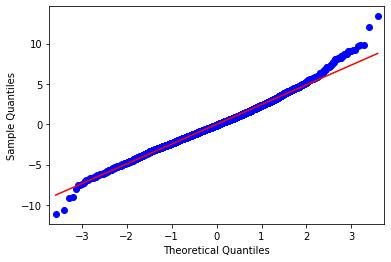

-1.931349866621653e-14

In [283]:
X2 = sm.add_constant(x_train)
#create OLS model
model = sm.OLS(y_train,X2)
est_ppg = model.fit()
print(est_ppg.summary())
_, pval, _, f_pval = diag.het_breuschpagan(est_ppg.resid,est_ppg.model.exog)
#print(pval,f_pval)
if pval > 0.05:
    print("p-value = {:.4}".format(pval))
    print('fail to reject the null, so there is no heteroscedasticity')
else:
    print("p-value = {:.4}".format(pval))
    print('Reject the null, there is heteroscedasticity')
#check for normality of residuals
sm.qqplot(est_ppg.resid,line='s')
pylab.show()
#check that mean of residuals is approx 0
mean_residuals = sum(est_ppg.resid) / len(est_ppg.resid)
mean_residuals

**Lasso**

In [254]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

lasso = Lasso()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
lasso_regressor = GridSearchCV(lasso, params, scoring = 'neg_mean_squared_error',cv=5)
lasso_regressor.fit(x_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

predict_lasso = lasso_regressor.predict(x_test)
RMSE(y_test,predict_lasso)#2.7368977967805495

{'alpha': 0.001}
-6.226233527054961


2.406523777321375

In [255]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold, cross_val_score

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_regressor = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

lasso_regressor.fit(x_train,y_train)

predict_lasso = lasso_regressor.predict(x_test)
RMSE(y_test,predict_lasso)#2.7727925322842575

2.4070469370637873

**Ridge**

In [396]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = Ridge()
params = {'alpha':[10, 20, 50,1e1, 1e2, 1e3, 1e5]}
ridge_regressor = GridSearchCV(ridge, params, scoring = 'neg_mean_squared_error',cv=5)
ridge_regressor.fit(x_train,y_train)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
predict_ridge = ridge_regressor.predict(x_test)
RMSE(y_test,predict_ridge)

{'alpha': 10}
-6.104540243529945


2.514744396418436

In [395]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = Ridge()
params = {'alpha':[10, 20, 50,1e1, 1e2, 1e3, 1e5]}
ridge_regressor = GridSearchCV(ridge, params, scoring = 'neg_mean_squared_error',cv=5)
ridge_regressor.fit(x_train,y_train)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
predict_ridge = ridge_regressor.predict(x_test)
RMSE(y_test,predict_ridge)

{'alpha': 10}
-6.104540243529945


2.514744396418436

**Elastic**

In [397]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
elastic_regressor = GridSearchCV(elastic, params, scoring = 'neg_mean_squared_error',cv=5)
elastic_regressor.fit(x_train, y_train)

print(elastic_regressor.best_params_)
print(elastic_regressor.best_score_)
predict_elastic = elastic_regressor.predict(x_test)
RMSE(y_test,predict_elastic)

{'alpha': 0.001}
-6.104125525103142


2.5147426696315134

In [518]:
from sklearn.linear_model import ElasticNetCV

elastic_regressor = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  
elastic_regressor.fit(x_train, y_train)
predict_elastic = elastic_regressor.predict(x_test)
RMSE(y_test,predict_elastic)

2.77372692528638

**Kernel Ridge**

In [400]:
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(alpha=1000)
params = {'alpha':[1,0]}
krr_regressor = GridSearchCV(krr, params, scoring = 'neg_mean_squared_error',cv=5)
krr_regressor.fit(x_train, y_train)

print(krr_regressor.best_params_)
print(krr_regressor.best_score_)

predict_krr = krr_regressor.predict(x_test)
RMSE(y_test,predict_krr)

{'alpha': 0}
-6.1172380208702615


2.514958045916307

**Gboost**

In [402]:
from sklearn.ensemble import GradientBoostingRegressor

gboost = GradientBoostingRegressor()
gboost_regressor = gboost.fit(x_train,y_train)
predict_gboost = gboost_regressor.predict(x_test)

RMSE(y_test,predict_gboost) #0.12879455202929072 - 3000 0.1287189253192443- 2000

2.517318682540105

In [523]:
# from sklearn.model_selection import GridSearchCV
# params = {'n_estimators':[4000], 'learning_rate':[.01,.1], 'max_depth':[5,10]}#, 'min_samples_leaf':[25], 'min_samples_split':[20,25],'random_state':[10,15]}
# tuning=GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = params, scoring='r2')
# tuning.fit(x_train,y_train)
# tuning.best_params_, tuning.best_score_

In [524]:
#gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=2, max_features='sqrt', min_samples_leaf=10, min_samples_split=25, loss='huber', random_state =10)
gboost = GradientBoostingRegressor(n_estimators=4000, learning_rate=0.01, max_depth=5, max_features='sqrt', min_samples_leaf=25, min_samples_split=20, loss='huber', random_state =15)
gboost = GradientBoostingRegressor()
gboost_regressor = gboost.fit(x_train,y_train)
predict_gboost = gboost_regressor.predict(x_test)

RMSE(y_test,predict_gboost)

3.313057587610187

**XGBoost**

In [389]:
from xgboost import XGBRegressor

xgboost = XGBRegressor()

xgboost_regressor = xgboost.fit(x_train.values,y_train.values)
predict_xgboost = xgboost_regressor.predict(x_test.values)

RMSE(y_test,predict_xgboost) #3.418322967389393

2.666696415247867

In [ ]:
params = {'learning_rate': [.05], 'n_estimators': [475], 'max_depth':[3],'min_child_weight':[0], 'gamma':[0], 'subsample':[0.5],
          'colsample_bytree':[1],'nthread':[-1],'scale_pos_weight':[1], 'seed':[20], 'reg_alpha':[1e-5]}
tuning=GridSearchCV(estimator = XGBRegressor(), param_grid = params, scoring='r2')
tuning.fit(x_train,y_train)
tuning.best_params_, tuning.best_score_

In [406]:
xgboost = XGBRegressor(learning_rate=0.05,n_estimators=475,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.5,
                                     colsample_bytree=1,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=20,
                                     reg_alpha=1e-5)

xgboost_regressor = xgboost.fit(x_train.values,y_train.values)
predict_xgboost = xgboost_regressor.predict(x_test.values)

RMSE(y_test,predict_xgboost)

2.5043938838316415

**LightGBM**

In [394]:
from lightgbm import LGBMRegressor

#lightgbm = LGBMRegressor(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
lightgbm = LGBMRegressor()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
lightgbm_regressor = GridSearchCV(lightgbm, params, scoring = 'neg_mean_squared_error',cv=5)
lightgbm_regressor.fit(x_train, y_train)

print(lightgbm_regressor.best_params_)
print(lightgbm_regressor.best_score_)
predict_lightgbm = lightgbm_regressor.predict(x_test)

RMSE(y_test,predict_lightgbm)

{'alpha': 1e-15}
-6.272215598120032


2.4942314542942503

In [529]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
lightgbm_regressor.fit(x_train, y_train)

predict_lightgbm = lightgbm_regressor.predict(x_test)

RMSE(y_test,predict_lightgbm)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


3.3979636925785965

**StackingCV Regressor**

In [407]:
from mlxtend.regressor import StackingCVRegressor

stack_gen = StackingCVRegressor(regressors=(rm_ppg, rf_ppg, ridge_regressor, lasso_regressor, elastic_regressor, krr_regressor, gboost_regressor, xgboost_regressor, lightgbm_regressor),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
stack_gen_model = stack_gen.fit(x_train, y_train)
stack_gen_model_predict = stack_gen_model.predict(np.array(x_test))
RMSE(stack_gen_model_predict, y_test)

2.4763014316845684

In [532]:
stack_gen_model_list = []
for i in stack_gen_model.predict(np.array(x_test)):
    a = []
    a.append(i)
    stack_gen_model_list.append(a)
stack_gen_model_array = np.asarray(stack_gen_model_list)

In [533]:
models = [rm_ppg, rf_ppg, ridge_regressor, lasso_regressor, elastic_regressor, krr_regressor, gboost_regressor, xgboost_regressor, lightgbm_regressor]
models_str = ['regression_model', 'rf', 'ridge_regressor', 'lasso_regressor', 'elastic_regressor', 'krr_regressor', 'gboost_regressor', 'xgboost_regressor', 'lightgbm_regressor']
ctr=0
for i in models:
    if i == 'stack_gen_model':
        pass
    else:
        print(models_str[ctr], RMSE(i.predict(x_test),y_test))
    ctr+=1

regression_model 2.7766013146219697
rf 3.475535133855888
ridge_regressor 2.7439087394526376
lasso_regressor 2.7727925322842575
elastic_regressor 2.7352883175830836
krr_regressor 2.775932127238594
gboost_regressor 3.2781945344685735
xgboost_regressor 3.2816928918626247
lightgbm_regressor 3.3094843036120163


In [560]:
n = 10
RMSE(list(map(sum, zip(rm_ppg.predict(x_test) * 1/n, 
                  rf_ppg.predict(x_test) * 1/n,
                  ridge_regressor.predict(x_test) * 1/n,
                  lasso_regressor.predict(x_test) * 1/n,
                  elastic_regressor.predict(x_test) * 1/n,
                  krr_regressor.predict(x_test) * 1/n,
                  gboost_regressor.predict(x_test) * 1/n,
                  xgboost_regressor.predict(x_test.values) * 1/n , 
                  lightgbm_regressor.predict(x_test) * 1/n,
                  stack_gen_model_array * 1/n,
                   )))
      , y_test)

2.922712310736132

In [561]:
def Blended_Models(features):
    n = 10
    stack_gen_model_predict = stack_gen_model.predict(np.array(features))
    stack_gen_model_list = []
    for i in stack_gen_model.predict(np.array(features)):
        a = []
        a.append(i)
        stack_gen_model_list.append(a)
    stack_gen_model_array = np.asarray(stack_gen_model_list)
    
    return list(map(sum, zip(rm_ppg.predict(features) * 1/n, 
                  rf_ppg.predict(features) * 1/n,
                  ridge_regressor.predict(features) * 1/n,
                  lasso_regressor.predict(features) * 1/n,
                  elastic_regressor.predict(features) * 1/n,
                  krr_regressor.predict(features) * 1/n,
                  gboost_regressor.predict(features) * 1/n,
                  xgboost_regressor.predict(features.values) * 1/n , 
                  lightgbm_regressor.predict(features) * 1/n,
                  stack_gen_model_array * 1/n,
                   )))